In [78]:
import pandas as pd
import numpy as np

df = pd.read_csv('bikeshare.csv')
df.head()

rand_state = 1000

In [1]:
pip install pycaret

  Using cached pycaret-3.3.0-py3-none-any.whl.metadata (17 kB)
  Using cached ipywidgets-8.1.2-py3-none-any.whl.metadata (2.4 kB)
  Using cached pyod-1.1.3-py3-none-any.whl
  Using cached imbalanced_learn-0.12.2-py3-none-any.whl.metadata (8.2 kB)
  Using cached category_encoders-2.6.3-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached lightgbm-4.3.0.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numba-0.59.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached xxhash-3.4.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached matplotlib-3.7.5-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.7 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)


In [79]:
df['overload'] = (df['cnt'] > 500).astype(int)

In [3]:
pd.crosstab(df['overload'],df['overload'], normalize='all')*100

overload,0,1
overload,,
0,92.640543,0.000000
1,0.000000,7.359457


The data is very imbalanced. 92% of the data is not overloaded. 

In [4]:
df.isnull().sum()/len(df)

season        0.0
yr            0.0
mnth          0.0
hr            0.0
holiday       0.0
weekday       0.0
notbizday     0.0
weathersit    0.0
temp          0.0
hum           0.0
windspeed     0.0
dteday        0.0
cnt           0.0
overload      0.0
dtype: float64

In [5]:
sum(df.duplicated())

0

In [6]:
df.nunique()

season          4
yr              2
mnth           12
hr             24
holiday         2
weekday         7
notbizday       2
weathersit      4
temp           50
hum            89
windspeed      30
dteday        731
cnt           869
overload        2
dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder

# changing the following columns to label encoding:
labeled_categoricals = ['dteday']

le = LabelEncoder()
le.fit_transform(df['dteday'])

mappings = {}
for column in labeled_categoricals:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    mappings[column] = le.classes_

In [8]:
df[labeled_categoricals] = df[labeled_categoricals].astype('category')  
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      17379 non-null  int64   
 1   yr          17379 non-null  int64   
 2   mnth        17379 non-null  int64   
 3   hr          17379 non-null  int64   
 4   holiday     17379 non-null  int64   
 5   weekday     17379 non-null  int64   
 6   notbizday   17379 non-null  int64   
 7   weathersit  17379 non-null  int64   
 8   temp        17379 non-null  float64 
 9   hum         17379 non-null  float64 
 10  windspeed   17379 non-null  float64 
 11  dteday      17379 non-null  category
 12  cnt         17379 non-null  int64   
 13  overload    17379 non-null  int64   
dtypes: category(1), float64(3), int64(10)
memory usage: 1.8 MB


#### Random Forest Classification

In [9]:
y = df['overload']
X = df.drop(columns = ['overload','cnt'], axis=1) # becareful inplace= False

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_state)

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Fitting RF classifier to the Training set

RF_classifier = RandomForestClassifier()
RF_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [11]:
# Predicting the Test set probabilities and classes
y_hat = RF_classifier.predict(X_test)
y_hat_probs = RF_classifier.predict_proba(X_test)[:,1] 

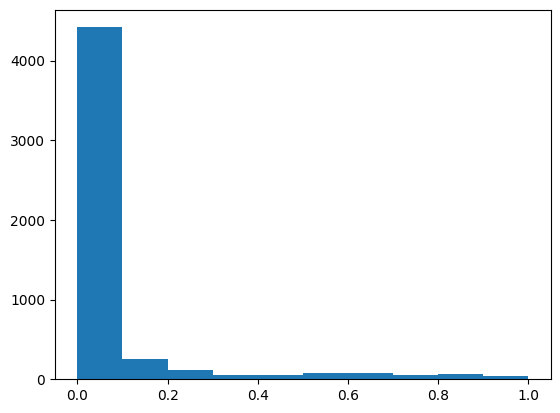

In [12]:
import matplotlib.pyplot as plt

plt.hist(y_hat_probs)
plt.show()

Majority of the predictions at a threshold of 0.5 would predict a 0. A threshold of 0.2 might make it more fair. 

In [13]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [14]:
print(confusion_matrix(y_test, y_hat))

[[4782   37]
 [ 113  282]]


The confusion matrix shows that the model predicting 4,786 of the 0's correctly and missed 115. It also correctly classified 280 1's correctly and missclassified 33 as 0's

In [15]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4819
           1       0.88      0.71      0.79       395

    accuracy                           0.97      5214
   macro avg       0.93      0.85      0.89      5214
weighted avg       0.97      0.97      0.97      5214



1. Precision is very high indicating that the model does a good job at predicting true positives. 
2. The recall for prediction 0 is very high and the recall for predicting 1 is 70% which isn't bad but it isn't very good. 
3. The F1 score also indicates that the model is better at predicting 0 than 1. 

The accuracy is very high at 94% which I don't believe because the model is good at predicting the 0 instances because the majority of instances were 0. 

In [16]:
my_param_grid = {'n_estimators':[100,200], 'criterion':['gini','entropy'],
                 'max_features':['log2'], 'max_depth':[10,None]}

In [17]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=RandomForestClassifier(random_state=rand_state),param_grid= my_param_grid, refit = True, verbose=2, cv=5 )
# verbose just means the text output describing the process. (the greater the number the more detail you will get).

In [18]:
# May take a while!
grid.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200; total tim

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1000),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, None], 'max_features': ['log2'],
                         'n_estimators': [100, 200]},
             verbose=2)

In [19]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'n_estimators': 200}

In [20]:
grid.best_estimator_

RandomForestClassifier(max_features='log2', n_estimators=200, random_state=1000)

In [21]:
y_hat_optimized = grid.predict(X_test)

In [22]:
print(confusion_matrix(y_test, y_hat_optimized))

[[4785   34]
 [ 114  281]]


In [23]:
print(classification_report(y_test, y_hat_optimized))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4819
           1       0.89      0.71      0.79       395

    accuracy                           0.97      5214
   macro avg       0.93      0.85      0.89      5214
weighted avg       0.97      0.97      0.97      5214



#### Cross Validated and OOB Accuracy

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
R2 = cross_val_score(estimator = RandomForestClassifier(max_depth=None, max_features='log2', n_estimators=200), X = X_train, y = y_train, cv = 5 )

In [26]:
R2_CV = round(np.mean(R2),4)
R2_CV

0.9716

##### OOB

In [27]:
np.random.choice(100,size=100)

array([59, 63, 20, 65, 76, 47,  5, 62, 58, 83, 32, 42, 51, 60, 88, 65,  1,
       69, 51, 28, 27, 76, 52,  5, 67, 45, 25, 60, 16,  4, 33,  0, 66,  2,
       37, 36, 24,  0, 82, 99, 69, 93, 79, 96, 58, 30, 87, 42, 19, 35, 72,
       67, 45,  8, 54, 75, 55, 99, 42, 96, 29, 76, 64, 95, 68, 91,  0, 13,
       86, 55, 98, 60, 68, 72, 47, 82, 41, 86, 41, 68, 47,  2,  3, 30, 45,
       27, 81, 11,  0, 18, 31,  6, 28, 82, 45, 33, 15, 28, 85, 35])

In [28]:
np.unique(np.random.choice (100,size=100)).size

63

In [29]:
RF_oob = RandomForestClassifier(max_depth=None, max_features='log2', n_estimators=200, oob_score=True)
RF_oob.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', n_estimators=200, oob_score=True)

In [30]:
RF_oob.oob_score_

0.9726263871763255

The OOB and CV accuracies are almost identical. This should indicate consistancy and that the model is actually performing well. 

#### Fixing Imbalanced Data

In [57]:
pd.crosstab(df['overload'],df['overload'], normalize='all')*100

overload,0,1
overload,,
0,92.640543,0.000000
1,0.000000,7.359457


In [58]:
y= df['overload']
np.bincount(y)

array([16100,  1279])

In [59]:
n_samples = y.shape[0]  
n_samples

17379

In [60]:
balanced_weights = n_samples / (np.bincount(y))
balanced_weights

array([ 1.07944099, 13.58795934])

In [61]:
# Normalize the weights
balanced_weights = balanced_weights / np.sum(balanced_weights)
balanced_weights

array([0.07359457, 0.92640543])

In [66]:
RF_balanced = RandomForestClassifier(n_estimators = 200, random_state=1000, criterion = 'gini', max_features='log2', max_depth=None, class_weight='balanced')

In [67]:
y_hat_balanced = RF_balanced.fit(X_train, y_train).predict(X_test)

In [68]:
print(confusion_matrix(y_test, y_hat_balanced))

[[4791   28]
 [ 118  277]]


In [69]:
print(classification_report(y_test, y_hat_balanced))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4819
           1       0.91      0.70      0.79       395

    accuracy                           0.97      5214
   macro avg       0.94      0.85      0.89      5214
weighted avg       0.97      0.97      0.97      5214



The recall number did not improve from the prior one. Balancing the data should have improved this. 

In [70]:
from sklearn.metrics import roc_curve, roc_auc_score

No Skill     : ROC AUC=0.500
Random Forest: ROC AUC=0.986


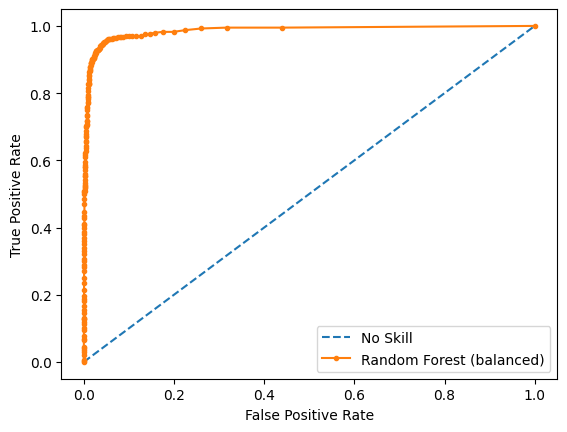

In [71]:
# generate a no skill (ns) prediction and logistic regression (lr) predictions.
ns_probs = [0 for i in range(len(y_test))]
lr_probs = RF_balanced.predict_proba(X_test)[:,1]
# calculating scores for no skill and logistic regression
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('No Skill     : ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest (balanced)')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

The AUC is 98.6 is much better than the no skill at 50

#### Feature Importance

In [73]:
RF_balanced.feature_importances_

array([0.02212557, 0.06161538, 0.03229473, 0.40267542, 0.00345244,
       0.03384255, 0.03383082, 0.01341071, 0.10576672, 0.07752484,
       0.03629188, 0.17716895])

In [74]:
RF_balanced.feature_names_in_

array(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'notbizday',
       'weathersit', 'temp', 'hum', 'windspeed', 'dteday'], dtype=object)

In [75]:
feature_importance_df = pd.DataFrame({'Features': RF_balanced.feature_names_in_ , 'Feature_importance':RF_balanced.feature_importances_}).sort_values(by=['Feature_importance'])
feature_importance_df

,Features,Feature_importance
4,holiday,0.003452
7,weathersit,0.013411
0,season,0.022126
2,mnth,0.032295
6,notbizday,0.033831
5,weekday,0.033843
10,windspeed,0.036292
1,yr,0.061615
9,hum,0.077525
8,temp,0.105767


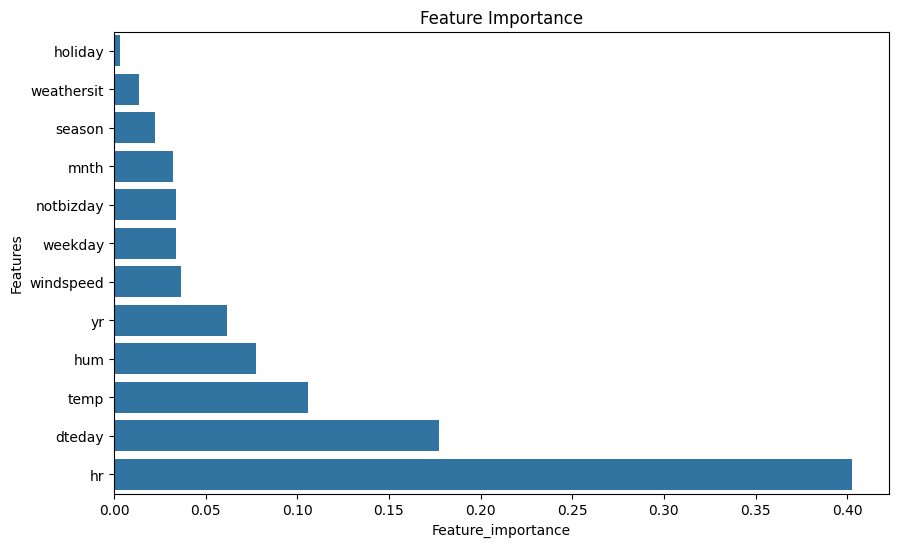

In [77]:
import seaborn as sns

plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(y='Features', x='Feature_importance', data=feature_importance_df)
plt.show()

These do make sense because they are almost identical to the order and variable as what was found in the Random Forest Regression and Linear Model. 